# Dependecies and libraries loading
here we load all of the dependecies and libraries we will need for the project

In [1]:
import pandas as pd # data analysis toolkit - create, read, update, delete datasets
import numpy as np #matrix math
from sklearn.model_selection import train_test_split #to split out training and testing data 
import torch
#for command line arguments
import argparse
#for reading files
import os
import cv2, os
import numpy as np
import matplotlib.image as mpimg
#for modeling
import torchvision, torch
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from skimage import io, transform
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import time
np.random.seed(0)
print('done')

done


# Nvidia's Model:
 NVIDIA model used
    Image normalization to avoid saturation and make gradients work better.<br>
    Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU<br>
    Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU<br>
    Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU<br>
    Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU<br>
    Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU<br>
    Drop out (0.5)<br>
    Fully connected: neurons: 100, activation: ELU<br>
    Fully connected: neurons: 50, activation: ELU<br>
    Fully connected: neurons: 10, activation: ELU<br>
    Fully connected: neurons: 1 (output)<br>

    the convolution layers are meant to handle feature engineering
    the fully connected layer for predicting the steering angle.
    dropout avoids overfitting
    ELU(Exponential linear unit) function takes care of the Vanishing gradient     problem. 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")
num_epochs=10
batch_size=32
learning_rate=0.001
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # self.resize = transforms.Resize((224, 224), antialias=True)
        self.conv1 = nn.Conv2d(3, 24, 5, stride=2)
        self.conv2 = nn.Conv2d(24, 36, 5, stride=2)
        self.conv3 = nn.Conv2d(36, 48, 5, stride=2)
        self.conv4 = nn.Conv2d(48,64,3)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(7616, 1000)# This might need to be adjusted depending on the input image size
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 10)
        self.fc5 = nn.Linear(10, 2)
        self.bn1 = nn.BatchNorm2d(24)
    def forward(self, x):
        x = x.reshape((-1, 3, 160, 320))
        # x = self.resize(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.pool4(x))
        x = x.view(x.size(0), -1) # This flattens the output of the conv layers
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)# No activation function is used for the output layer
        return x


model = Net().to(device)
criterion=nn.MSELoss()
optimizer= torch.optim.Adam(model.parameters(),lr=learning_rate)
print("done")

GPU is not available, using CPU instead
done


# The DataLoader
This DataLoader was made using pytorch DataLoader class it has an intialization __init__() where we would define the inputs of the dataloader a __len()__ function to retain the length of the data input a __getitem()__ function to transform and return the data to be ready to use  

In [3]:
class cam (torch.utils.data.Dataset):
    """cam dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.cam_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.img_name= self.cam_frame.iloc[:,0]
        self.transform = transform
        self.y = self.cam_frame.iloc[:, 3]
        self.z = self.cam_frame.iloc[:, 4]

    def __len__(self):
        return len(self.cam_frame)

    def __getitem__(self, index):
        img=Image.open(os.path.join(self.root_dir,
                                self.img_name[index]))

        if self.transform:
            sample = self.transform(img)
        label1 = self.y[index]
        label2 = self.z[index]
        return sample,label1,label2

# DataLoading
Here we load the data using the Data loader class

In [4]:
transform_car = transforms.Compose([transforms.ToTensor()])
train_dataset = cam(csv_file="brbr\driving_log.csv",root_dir = "brbr\IMG",transform=transform_car )
train_loader=DataLoader(dataset=train_dataset,batch_size=32,drop_last=True,shuffle=True,num_workers=0)

In [5]:
valid_dataset =cam(csv_file="valid\driving_log.csv",root_dir = "valid\IMG",transform=transform_car )
valid_loader=DataLoader(dataset=valid_dataset,batch_size=100,shuffle=False,num_workers=0)

# Model training and validation 
here we train the model using a __train_model()__ function made to train and validate the model and save the model with best validation result

In [6]:
def train_model(model, num_epochs, train_loader,
                valid_loader, optimizer, device):
    min_valid_loss=7.8
    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, data in enumerate(train_loader):

            features,targets1,targets2 = data
            features = features.to(device)
            targets1 = targets1.to(device)
            targets2 = targets2.to(device)
            

            # ## FORWARD AND BACK PROP
            logits1,logits2= torch.split(model(features),1,dim =1) 
            loss1 = criterion(logits1.view(-1,1), targets1.to(torch.float32).view(-1,1))
            loss2 = criterion(logits2.view(-1,1),targets2.to(torch.float32).view(-1,1))
            loss = loss1 + loss2
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % 50:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        valid_loss = 0.0
        model.eval()     # Optional when not using Model Specific layer
        for batch_idx_val, data_val in enumerate(valid_loader):

            features_val,targets1_val,targets2_val = data_val
            features_val = features_val.to(device)
            targets1_val = targets1_val.to(device)
            targets2_val = targets2_val.to(device)
            

            logits1_val,logits2_val = torch.split(model(features_val), 1,dim =1)
            loss1_val = criterion(logits1_val.view(-1,1), targets1_val.to(torch.float32).view(-1,1))
            loss2_val = criterion(logits2_val.view(-1,1),targets2_val.to(torch.float32).view(-1,1))
            valid_loss = loss1_val + loss2_val
            valid_acc_list.append(valid_loss.item())
            print(f'Epoch {epoch+1:03d}/{num_epochs:03d} \t\t Validation Loss: {valid_loss}')
            if min_valid_loss > valid_loss:
                print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
                min_valid_loss = valid_loss
                # Saving State Dict
                torch.save(model, 'saved_model.pth')

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')

    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    return minibatch_loss_list, valid_acc_list

In [7]:
minibatch_loss_list,valid_acc_list=train_model(model=model,num_epochs=20,
                                train_loader=train_loader,
                                valid_loader=valid_loader,
                                optimizer=optimizer,
                                device=device)

Epoch: 001/020 | Batch 0000/0290 | Loss: 0.7356
Epoch: 001/020 | Batch 0050/0290 | Loss: 0.0387
Epoch: 001/020 | Batch 0100/0290 | Loss: 0.0215
Epoch: 001/020 | Batch 0150/0290 | Loss: 0.0395
Epoch: 001/020 | Batch 0200/0290 | Loss: 0.0341
Epoch: 001/020 | Batch 0250/0290 | Loss: 0.0337
Epoch 001/020 		 Validation Loss: 0.16581127047538757
Validation Loss Decreased(7.800000--->0.165811) 	 Saving The Model
Epoch 001/020 		 Validation Loss: 0.027686655521392822
Validation Loss Decreased(0.165811--->0.027687) 	 Saving The Model
Epoch 001/020 		 Validation Loss: 0.0037834758404642344
Validation Loss Decreased(0.027687--->0.003783) 	 Saving The Model
Epoch 001/020 		 Validation Loss: 0.0034551993012428284
Validation Loss Decreased(0.003783--->0.003455) 	 Saving The Model
Epoch 001/020 		 Validation Loss: 0.007924875244498253
Epoch 001/020 		 Validation Loss: 0.002537522930651903
Validation Loss Decreased(0.003455--->0.002538) 	 Saving The Model
Epoch 001/020 		 Validation Loss: 0.0169395096

<function matplotlib.pyplot.show(close=None, block=None)>

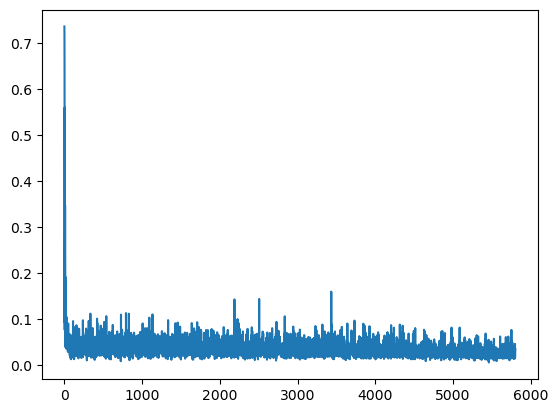

In [8]:
plt.plot(minibatch_loss_list)
plt.show

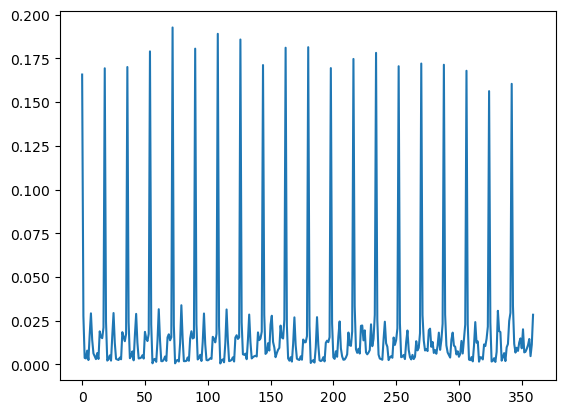

In [9]:
plt.plot(valid_acc_list)

In [10]:
 torch.save(model, 'x_model.pth')

In [11]:
examples= iter(train_loader)
example_data = next(examples)
images, steering_angle,throttle = example_data
images = images.to(device)
steering_angle=steering_angle.to(device)
throttle = throttle.to(device)
preds=model(images)
print([preds])
print([steering_angle])
print([throttle])

[tensor([[ 0.2449,  0.9619],
        [-0.0620,  1.0010],
        [-0.0641,  1.0013],
        [ 0.0667,  0.9846],
        [ 0.0691,  0.9843],
        [-0.0116,  0.9946],
        [ 0.0101,  0.9918],
        [-0.0209,  0.9958],
        [-0.0274,  0.9966],
        [ 0.0182,  0.9908],
        [-0.0925,  1.0049],
        [-0.1538,  1.0127],
        [ 0.0834,  0.9825],
        [-0.1858,  1.0168],
        [-0.0795,  1.0032],
        [-0.0075,  0.9941],
        [ 0.0122,  0.9916],
        [ 0.0203,  0.9905],
        [ 0.1019,  0.9801],
        [-0.1575,  1.0132],
        [ 0.0232,  0.9902],
        [ 0.0453,  0.9873],
        [ 0.0487,  0.9869],
        [-0.0752,  1.0027],
        [-0.0810,  1.0034],
        [-0.0250,  0.9963],
        [ 0.1513,  0.9738],
        [-0.0323,  0.9972],
        [ 0.0682,  0.9844],
        [-0.0459,  0.9990],
        [ 0.1150,  0.9785],
        [ 0.1522,  0.9737]], grad_fn=<AddmmBackward0>)]
[tensor([ 0.4159, -0.1623,  0.0000,  0.0000,  0.0940, -0.0962,  0.0000,  0.